In [1]:
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from torchmetrics import Accuracy, F1Score, Precision, Recall, AUROC
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
from preprocess import create_lineup_graph, add_reversed_negatives

In [3]:
df = pd.read_csv('../get_lineup_target_score/nba_with_lineup_score.csv')
pre_df = pd.read_csv('../pre_season/pre_lineup_vs_lineup.csv')
pre_player_stats_df = pd.read_csv('../../data/player_stats_2023-24.csv')

In [4]:
data = create_lineup_graph(df, pre_df, pre_player_stats_df)

In [5]:
data

Data(x=[858, 17], edge_index=[2, 855], edge_attr=[855, 1], num_nodes=858)

# Training

In [6]:
from model import LitGNN
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl

In [7]:
batch_size = 1
train_data, val_data, test_data = RandomLinkSplit(num_val=0.1, num_test=0.1)(data)
train_data = add_reversed_negatives(train_data)
val_data = add_reversed_negatives(val_data)
test_data = add_reversed_negatives(test_data)
train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)
test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

In [ ]:
best_model_parameters = {
    'hidden_dim': 256,
    'num_conv_layers': 2,
    'num_linear_layers': 2,
    'lr': 0.001,
    'weight_decay': 0.0001,
    'dropout': 0.5,
}

In [ ]:
model = LitGNN(
            input_dim=data.x.shape[1],
            conv_layers=best_model_parameters['num_conv_layers'],
            link_predictor_layers=best_model_parameters['num_linear_layers'],
            conv_hidden_dim=config.hidden_dim,
            link_hidden_dim=config.hidden_dim,
            learning_rate=config.lr,
            weight_decay=config.weight_decay,
            dropout_rate=config.dropout
        )
trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min'),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
    ],
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

# Evaluation

In [6]:
from evaluation import evaluate_model, visualize_whole_graph

In [ ]:
evaluate_model(model, test_data, random_seed=42)

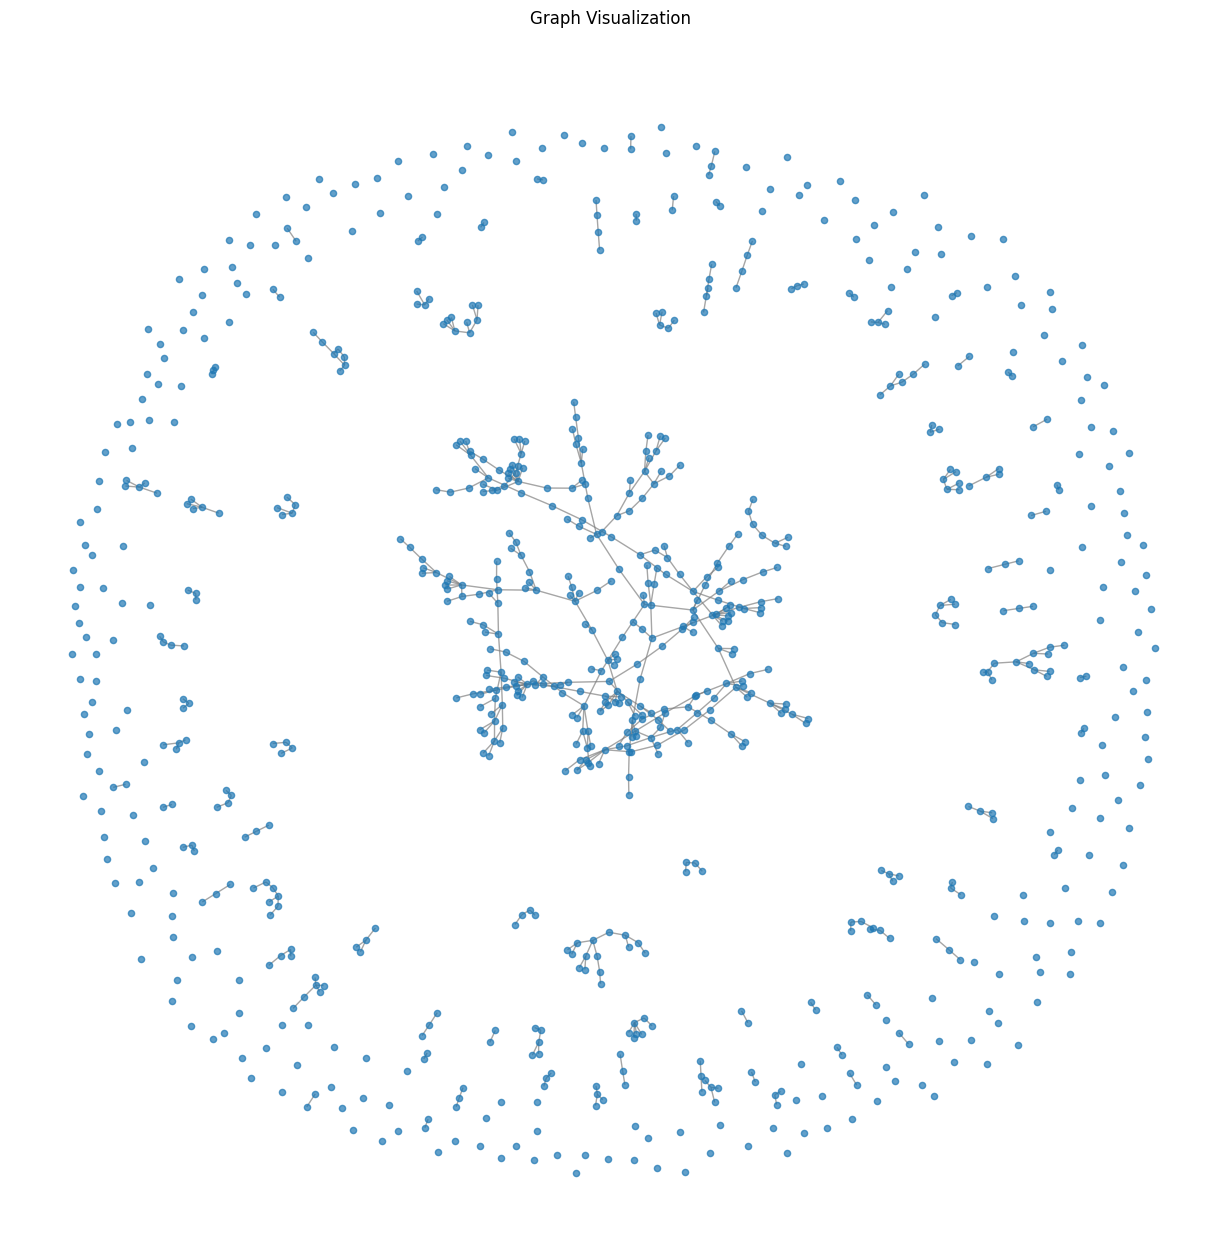

In [7]:
visualize_whole_graph(data=data)

In [ ]:
from model import LitGNN
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt

def forward(self, x, edge_index, edge_attr=None):
    x = self.gnn(x, edge_index, edge_attr)  
    src, dst = edge_index
    edge_embeddings = torch.cat([x[src], x[dst]], dim=1)
    return self.link_predictor(edge_embeddings) 


# === Data Setup ===
batch_size = 1
train_data, val_data, test_data = RandomLinkSplit(num_val=0.1, num_test=0.1)(data)
train_data = add_reversed_negatives(train_data)
val_data = add_reversed_negatives(val_data)
test_data = add_reversed_negatives(test_data)
train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)
test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

# === Model Setup ===
best_model_parameters = {
    'conv_layers': 2,
    'conv_hidden_dim': 64,
    'link_predictor_layers': 2,
    'link_hidden_dim': 64,
    'lr': 0.001,
    'weight_decay': 0.0001,
    'dropout': 0.5,
}

model = LitGNN(input_dim=data.x.shape[1])

trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min'),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
    ],
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

# === Feature Importance via Gradient Attribution ===
model.eval()
batch = next(iter(test_loader)).to(model.device)
batch.x.requires_grad = True
edge_label_index = batch.edge_label_index  
node_embeddings = model(
    x=batch.x,
    edge_index=batch.edge_index,
    edge_attr=batch.edge_attr if hasattr(batch, 'edge_attr') else None
)

src, dst = edge_label_index
u_emb = node_embeddings[src]
v_emb = node_embeddings[dst]
output = model.link_predictor(u_emb, v_emb).squeeze()

loss = torch.nn.functional.binary_cross_entropy_with_logits(output, batch.edge_label.float())
loss.backward()

feature_importance = batch.x.grad.abs().mean(dim=0).cpu().detach().numpy()




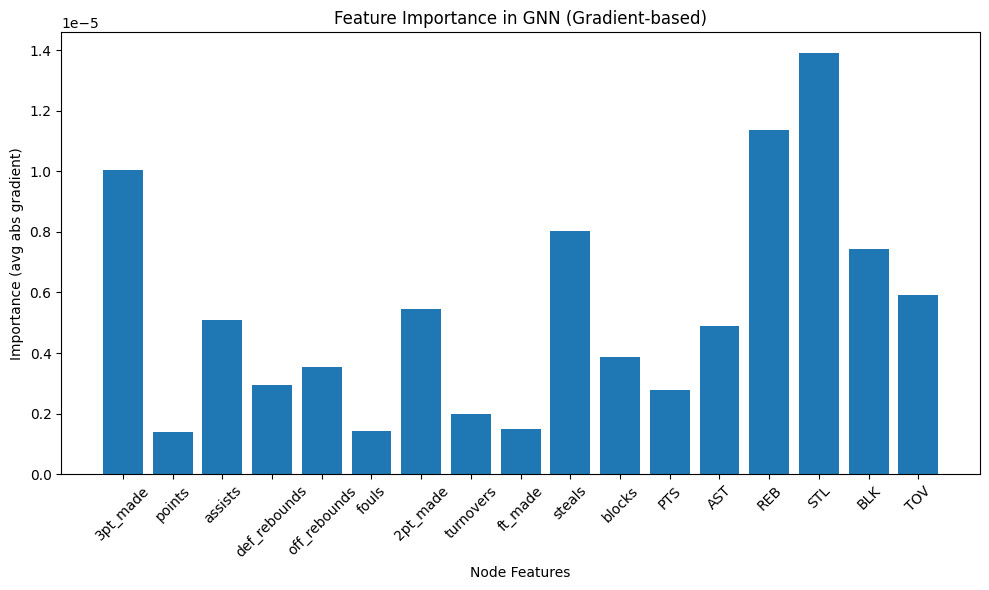

In [14]:
feature_names = ['3pt_made', 'points', 'assists', 'def_rebounds', 'off_rebounds', 'fouls', '2pt_made', 'turnovers', 'ft_made', 'steals', 'blocks', 'PTS', 'AST', 'REB', 'STL', 'BLK', 'TOV']
#feature_names = [f'Feature {i}' for i in range(data.x.shape[1])]
#feature_names = df.columns.tolist()


# === Plot Feature Importance ===

plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.xlabel('Node Features')
plt.ylabel('Importance (avg abs gradient)')
plt.title('Feature Importance in GNN (Gradient-based)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()